In [ ]:
import configuration

from pycontractions import Contractions
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
from src import clean_tweet
import seaborn as sns
import pandas as pd
import numpy as np
tqdm.pandas()
import re

import glob
import os
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")
folder_from = '../data/datasets/'

In [2]:
data = pd.read_csv('../data/unified/Unified_MultiCrisis_Dataset.csv', encoding = 'utf8')
data.shape

(164625, 16)

# Domain and language selection

In [3]:
def count_hazard(data, lang, n):
    return data[data.lan_final==lang].groupby(
        ['hazard_type']).count()[['tweet_id']].sort_values(
        'tweet_id', ascending=False).head(n)  

count_hazard(data, 'en', 5), count_hazard(data, 'es', 4), count_hazard(data, 'it', 4)

(             tweet_id
 hazard_type          
 flood           28945
 earthquake      25003
 hurricane       19244
 typhoon         12683
 explosion       10853,
              tweet_id
 hazard_type          
 earthquake       9995
 explosion         925
 derailment        609
 landslide         234,
              tweet_id
 hazard_type          
 earthquake       4721
 flood            2165
 landslide          56
 hurricane          16)

In [5]:
selected_domains = ['earthquake','flood', 'explosion']
selected_languages = ['en','es', 'it']
data = data[(data.hazard_type.isin(selected_domains)) & (data.lan_final.isin(selected_languages))]

data = data[~(((data.hazard_type=='explosion') & (data.lan_final=='it'))|
             ((data.hazard_type=='flood') & (data.lan_final=='es')))]
data.shape

(82607, 16)

# Additional Preprocessing

## Removing replies from Ecuador-Earthquake

In [7]:
## Removing replies
import re
def is_reply(tweet): 
    tweet = str(tweet) 
    return True if re.search("^@\w+", tweet) else False 

data['isreply'] = data['tweet_text'].apply(is_reply)
data = data[~((data.dataset=='ESPOL_Ecuador_earthquake') & (data.isreply==True))]
data.shape

(79417, 17)

## Excluding tweets with truncated text from ChileEarthquakeT1

In [8]:
## Selecting the downloaded messages by tweet ID and replacing their text. 
chile_down = pd.read_csv(folder_from + 'Chile earthquake/Chile_uniques_downloaded.csv', encoding='utf_8')
data = data[~((data.dataset=='ChileEarthquakeT1') & (~data.tweet_id.isin(set(chile_down.id))))]
data.shape

(78782, 17)

## Removing duplicates by text

In [9]:
#Remove all retweet symbol, urls, users, emojis, hashtags, cashtag, numbers, symbols...
data['fixed_clean_total'] = [clean_tweet.clean_tweet_totally(tweet, lower=True) for tweet in tqdm_notebook(data.fixed_text)]
data['fixed_clean_total'] = data['fixed_clean_total'].astype(str)

In [10]:
data = data.drop_duplicates(subset=['fixed_clean_total'], keep='first')
data = data.reset_index(drop=True)
data.shape

(68856, 18)

## Expanding english constractions

In [11]:
#model from the gensim.downloader api
cont = Contractions(api_key="glove-twitter-100")
cont.load_models()

In [12]:
data['fixed_text_expanded'] = data['fixed_text']
data.loc[(data.lan_final=='en') , 'fixed_text_expanded'] = data.fixed_text.progress_apply(lambda text: " ".join(list(cont.expand_texts([text], precise=True))))

100%|███████████████████████████████████████████████████████████████████████████| 68856/68856 [05:06<00:00, 224.65it/s]


In [13]:
#Remove all retweet symbol, urls, users, emojis, hashtags, cashtag, numbers, symbols over the expanded text
data['fixed_clean_total'] = [clean_tweet.clean_tweet_totally(tweet, lower=True) for tweet in tqdm_notebook(data.fixed_text_expanded)]
data['fixed_clean_total'] = data['fixed_clean_total'].astype(str)

## Removing near-duplicates by language

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from collections import defaultdict

In [5]:
data['fixed_text_expanded_lower'] = data['fixed_text_expanded'].str.lower()
data[['fixed_text_expanded_lower', 'fixed_text_expanded']].head(2)

,fixed_text_expanded_lower,fixed_text_expanded
0,fuentes sobre el terremoto en chile http://bit.ly/auedsj,Fuentes sobre el terremoto en Chile http://bit.ly/aUedsj
1,sube el parte de víctimas: las autoridades chilenas informan de que al menos 64 personas fallecieron en las... http://bit.ly/awx73m,Sube el parte de víctimas: las autoridades chilenas informan de que al menos 64 personas fallecieron en las... http://bit.ly/awX73M


In [6]:
def vectorizer(lan_tag):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(data[data.lan_final==lan_tag].fixed_text_expanded_lower)

In [7]:
X_en = vectorizer('en')
X_es = vectorizer('es')
X_it = vectorizer('it')
X_en.shape, X_es.shape, X_it.shape

((54815, 87816), (7809, 20192), (6232, 11558))

In [8]:
X_es = X_es.astype(np.float32)
X_en = X_en.astype(np.float32)
X_it = X_it.astype(np.float32)
X_en.shape, X_es.shape, X_it.shape

((54815, 87816), (7809, 20192), (6232, 11558))

In [9]:
it_similarity = pairwise_distances(X_it, metric='cosine')
it_similarity = it_similarity.astype(np.float16)

In [10]:
es_similarity = pairwise_distances(X_es, metric='cosine')
es_similarity = es_similarity.astype(np.float16)

In [11]:
en_similarity = pairwise_distances(X_en, metric='cosine')
en_similarity = en_similarity.astype(np.float16)

In [12]:
#similarity threshold
th = 0.25

In [13]:
def update_duplicates(dist, index, closeness, duplicates, idx):
    for (d, i) in zip(dist[1:50], index[1:50]):
        if d <= th:
            duplicates.add(i)
            closeness[idx].append(i)
        else:
            break

In [14]:
def plot_heatmap(distance_lang_sort, duplicates, uniques):
    plt.figure(figsize=(10, 7))
    sns.heatmap(distance_lang_sort[:,1:50], cmap='Spectral', vmin=0)
    
    plt.figure(figsize=(10, 1))
    sns.heatmap(distance_lang_sort[list(duplicates),1:50], cmap='Spectral', vmin=0)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(distance_lang_sort[list(uniques),1:50], cmap='Spectral')    

### Spanish tweets

In [15]:
similarity_lang = es_similarity
data_lang = data[data.lan_final=='es']

index_lang = np.argsort(similarity_lang, axis=1)
distance_lang_sort = np.take_along_axis(similarity_lang, index_lang, axis=1)

duplicates, uniques = set(), set()
closeness = defaultdict(list)

for dist, index in zip(distance_lang_sort, index_lang):
    
    if index[0] not in duplicates:
        uniques.add(index[0])
        update_duplicates(dist, index, closeness, duplicates, index[0])
    
                                        
es_uniques_df = data_lang.iloc[list(uniques)]
len(duplicates), len(uniques), len(closeness), len(data_lang)

(118, 7691, 105, 7809)

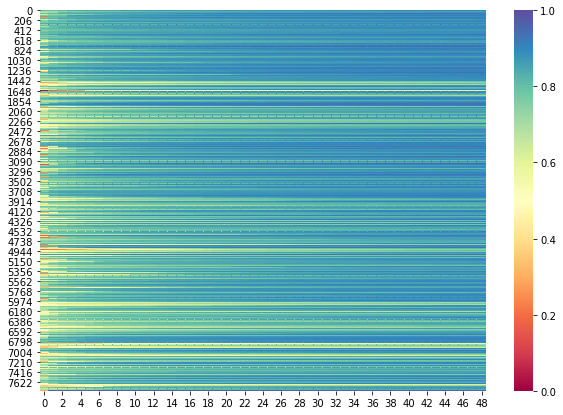

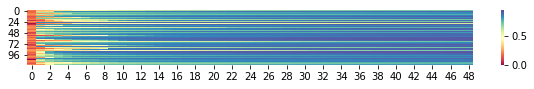

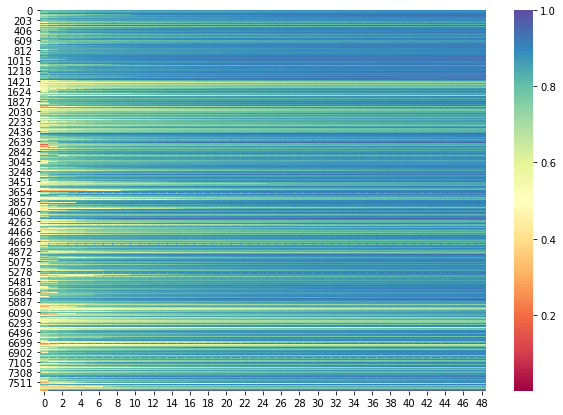

In [16]:
plot_heatmap(distance_lang_sort, duplicates, uniques)

### Italian tweets

In [18]:
similarity_lang = it_similarity
data_lang = data[data.lan_final=='it']

index_lang = np.argsort(similarity_lang, axis=1)
distance_lang_sort = np.take_along_axis(similarity_lang, index_lang, axis=1)

duplicates, uniques = set(), set()
closeness = defaultdict(list)

for dist, index in zip(distance_lang_sort, index_lang):
    
    if index[0] not in duplicates:
        uniques.add(index[0])
        update_duplicates(dist, index, closeness, duplicates, index[0])
    
                                        
it_uniques_df = data_lang.iloc[list(uniques)]
len(duplicates), len(uniques), len(closeness), len(data_lang)

(313, 5919, 258, 6232)

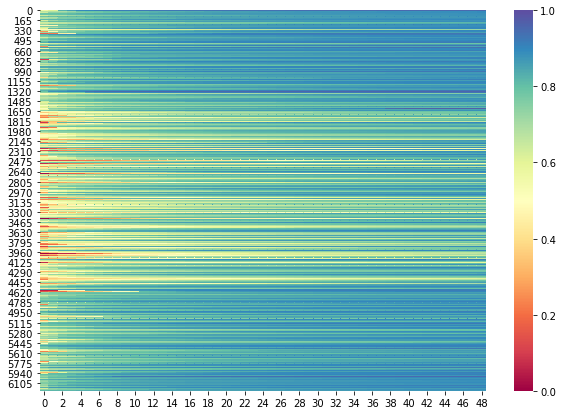

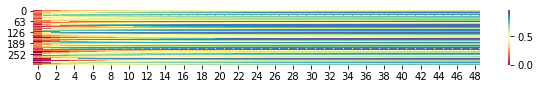

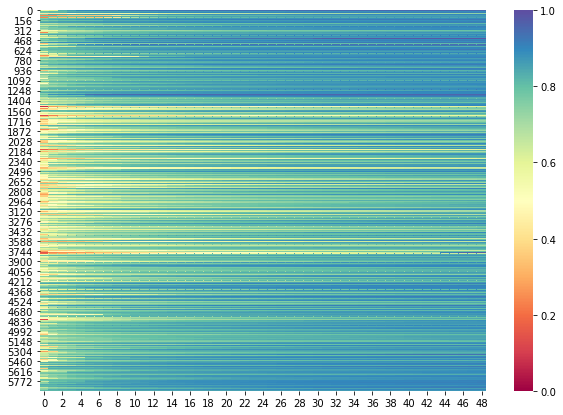

In [19]:
plot_heatmap(distance_lang_sort, duplicates, uniques)

### English tweets

In [21]:
similarity_lang = en_similarity
data_lang = data[data.lan_final=='en']

index_lang = np.argsort(similarity_lang, axis=1)
distance_lang_sort = np.take_along_axis(similarity_lang, index_lang, axis=1)

duplicates, uniques = set(), set()
closeness = defaultdict(list)

for dist, index in zip(distance_lang_sort, index_lang):
    
    if index[0] not in duplicates:
        uniques.add(index[0])
        update_duplicates(dist, index, closeness, duplicates, index[0])
    
                                        
en_uniques_df = data_lang.iloc[list(uniques)]
len(duplicates), len(uniques), len(closeness), len(data_lang)

(1135, 53680, 1016, 54815)

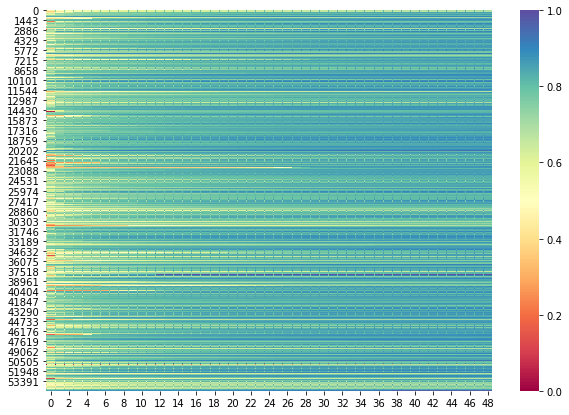

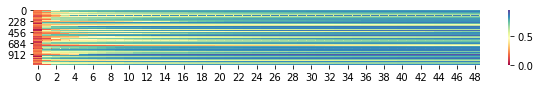

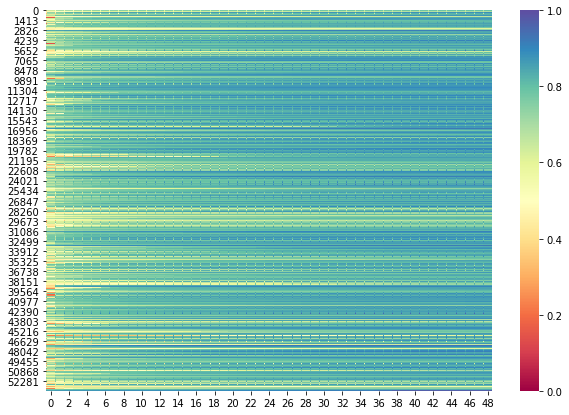

In [22]:
plot_heatmap(distance_lang_sort, duplicates, uniques)

### joining uniques tweets by language

In [ ]:
data = en_uniques_df.append(es_uniques_df, ignore_index=True)
data = data.append(it_uniques_df, ignore_index=True).reset_index(drop=True)

In [25]:
data['mapped_label_bin'] = data['mapped_label'].map(lambda x: x.replace('Not_Related', '0').replace('Related', '1'))
data['mapped_label_bin'] = data['mapped_label_bin'].astype(np.int)

In [33]:
cols =['tweet_id', 'tweet_text', 'fixed_text_expanded', 
       'fixed_clean_total', 'dataset', 'crisis', 'country', 'year',
       'lan_final', 'hazard_type', 'hazard_cat', 'hazard_subcat',
       'development', 'spread', 'original_label', 'mapped_label_bin']


data[cols].to_csv('../data/selected/Subset_Data_Uniques.csv', encoding='utf8', index=False)
len(data)

67290

Then, we removed events with less than 100 tweets per language and domain, totaling 67001 tweets for our experimentation. 
Finally, we translated non-english tweets and relabeled some tweets from CrisisMMD and CrisisLexT26 datasets.
Therefore, we create the new columns 'translated' and 'label'.